# TRM Data Exploration

Understanding the dataset structure for the few-shot demo encoder project.

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from collections import Counter
import sys
sys.path.insert(0, '..')

## 1. Dataset Structure Overview

The TRM dataset has a 3-level hierarchy:
- **Groups**: Original base puzzles (960 = 400 training + 400 eval + 160 concept)
- **Puzzles**: Each group has ~1000 augmented versions (dihedral transform + color permutation)
- **Examples**: Individual (input, output) pairs within each puzzle (2-5 per puzzle)

In [2]:
# Load train data
DATA_PATH = '../data/arc1concept-aug-1000'

inputs = np.load(f'{DATA_PATH}/train/all__inputs.npy', mmap_mode='r')
labels = np.load(f'{DATA_PATH}/train/all__labels.npy', mmap_mode='r')
puzzle_identifiers = np.load(f'{DATA_PATH}/train/all__puzzle_identifiers.npy', mmap_mode='r')
puzzle_indices = np.load(f'{DATA_PATH}/train/all__puzzle_indices.npy', mmap_mode='r')
group_indices = np.load(f'{DATA_PATH}/train/all__group_indices.npy', mmap_mode='r')

with open(f'{DATA_PATH}/identifiers.json') as f:
    identifiers = json.load(f)

print('=== Array shapes ===')
print(f'inputs: {inputs.shape}, dtype: {inputs.dtype}')
print(f'labels: {labels.shape}, dtype: {labels.dtype}')
print(f'puzzle_identifiers: {puzzle_identifiers.shape}')
print(f'puzzle_indices: {puzzle_indices.shape}')
print(f'group_indices: {group_indices.shape}')
print(f'identifiers: {len(identifiers)} entries')

=== Array shapes ===
inputs: (3633410, 900), dtype: uint8
labels: (3633410, 900), dtype: uint8
puzzle_identifiers: (876405,)
puzzle_indices: (876406,)
group_indices: (961,)
identifiers: 876406 entries


In [3]:
inputs[0]

memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## 2. Token Encoding

- 0 = PAD (padding)
- 1 = EOS (end of sequence marker)
- 2-11 = colors 0-9 (actual grid values + 2)

In [4]:
# ARC color palette
ARC_COLORS = [
    '#000000',  # 0: black
    '#0074D9',  # 1: blue
    '#FF4136',  # 2: red
    '#2ECC40',  # 3: green
    '#FFDC00',  # 4: yellow
    '#AAAAAA',  # 5: gray
    '#F012BE',  # 6: magenta
    '#FF851B',  # 7: orange
    '#7FDBFF',  # 8: cyan
    '#870C25',  # 9: maroon
]

def tokens_to_colors(tokens):
    """Convert token values to actual ARC colors (0-9)."""
    # tokens: 0=PAD, 1=EOS, 2-11=colors 0-9
    colors = np.clip(tokens - 2, 0, 9)
    return colors

def plot_grid(grid_flat, ax, title=''):
    """Plot a 30x30 flattened grid."""
    grid = grid_flat.reshape(30, 30)
    
    # Find actual content bounds (non-PAD, non-EOS)
    content_mask = (grid > 1)  # Actual colors are 2-11
    if content_mask.any():
        rows = np.any(content_mask, axis=1)
        cols = np.any(content_mask, axis=0)
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
    else:
        rmin, rmax, cmin, cmax = 0, 29, 0, 29
    
    # Extract and convert to colors
    subgrid = grid[rmin:rmax+1, cmin:cmax+1]
    colors = tokens_to_colors(subgrid)
    
    # Create color image
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(ARC_COLORS)
    
    ax.imshow(colors, cmap=cmap, vmin=0, vmax=9)
    ax.set_title(title)
    ax.axis('off')
    
    # Add grid lines
    for i in range(colors.shape[0] + 1):
        ax.axhline(i - 0.5, color='gray', linewidth=0.5)
    for j in range(colors.shape[1] + 1):
        ax.axvline(j - 0.5, color='gray', linewidth=0.5)

## 3. Visualize a Puzzle

Each puzzle (one augmentation) contains multiple input/output example pairs.

Puzzle index: 0
Name: 8be77c9e
Examples: 4



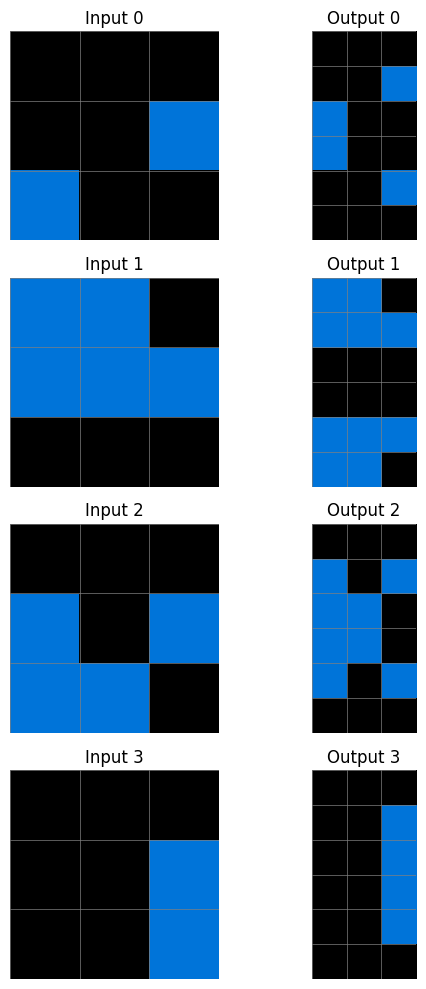

In [5]:
def visualize_puzzle(puzzle_idx):
    """Visualize all examples in a puzzle."""
    # Get puzzle info
    pid = puzzle_identifiers[puzzle_idx]
    name = identifiers[pid]
    start = puzzle_indices[puzzle_idx]
    end = puzzle_indices[puzzle_idx + 1]
    num_examples = end - start
    
    print(f'Puzzle index: {puzzle_idx}')
    print(f'Name: {name}')
    print(f'Examples: {num_examples}')
    print()
    
    # Plot each example
    fig, axes = plt.subplots(num_examples, 2, figsize=(6, 2.5 * num_examples))
    if num_examples == 1:
        axes = axes.reshape(1, 2)
    
    for i in range(num_examples):
        idx = start + i
        plot_grid(inputs[idx], axes[i, 0], f'Input {i}')
        plot_grid(labels[idx], axes[i, 1], f'Output {i}')
    
    plt.tight_layout()
    plt.show()

# Visualize first puzzle (base, no augmentation)
visualize_puzzle(0)

In [ ]:
# Visualize an augmented version of the same puzzle
visualize_puzzle(1)

## 4. Examples per Puzzle Distribution

=== Distribution of examples per puzzle (train split) ===
  2 examples: 41357 puzzles (4.7%)
  3 examples: 247211 puzzles (28.2%)
  4 examples: 295982 puzzles (33.8%)
  5 examples: 172294 puzzles (19.7%)
  6 examples: 88331 puzzles (10.1%)
  7 examples: 24347 puzzles (2.8%)
  8 examples: 2578 puzzles (0.3%)
  9 examples: 2152 puzzles (0.2%)
  10 examples: 1001 puzzles (0.1%)
  11 examples: 576 puzzles (0.1%)
  12 examples: 576 puzzles (0.1%)

Total puzzles: 876405
Min: 2, Max: 12, Mean: 4.15


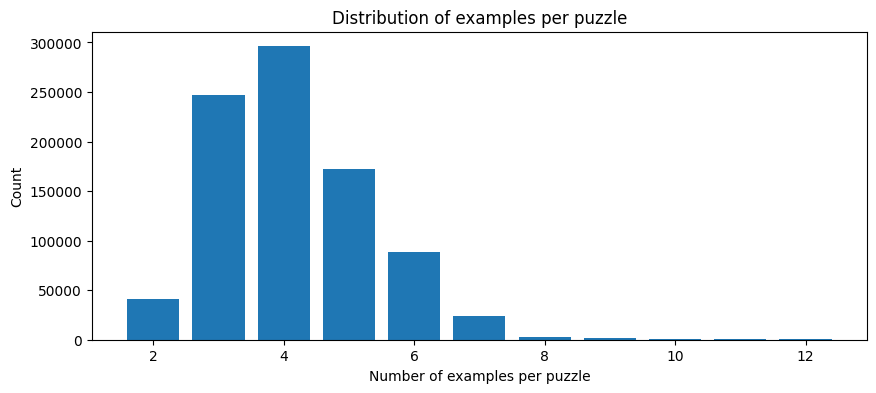

In [ ]:
# Count examples per puzzle
example_counts = np.diff(puzzle_indices)
counter = Counter(example_counts)

print('=== Distribution of examples per puzzle (train split) ===')
for count, freq in sorted(counter.items()):
    print(f'  {count} examples: {freq} puzzles ({100*freq/len(example_counts):.1f}%)')

print(f'\nTotal puzzles: {len(example_counts)}')
print(f'Min: {min(example_counts)}, Max: {max(example_counts)}, Mean: {np.mean(example_counts):.2f}')

# Plot
plt.figure(figsize=(10, 4))
plt.bar(counter.keys(), counter.values())
plt.xlabel('Number of examples per puzzle')
plt.ylabel('Count')
plt.title('Distribution of examples per puzzle')
plt.show()

## 5. Test the Few-Shot Dataset

In [ ]:
from fewshot_puzzle_dataset import FewShotDataset, FewShotDatasetConfig, FewShotEvalDataset

# Create training dataset
config = FewShotDatasetConfig(
    seed=42,
    dataset_paths=['../data/arc1concept-aug-1000'],
    global_batch_size=4,
    min_demos=1,
    max_demos=5,
)

dataset = FewShotDataset(config, split='train')
print(f'Metadata: {dataset.metadata}')
print(f'Valid puzzles: {len(dataset.valid_puzzle_indices)}')

Metadata: seq_len=900 vocab_size=12 pad_id=0 num_puzzles=876405 max_examples_per_puzzle=12
Valid puzzles: 876405


Batch shapes:
  demo_inputs: torch.Size([4, 3, 900])
  demo_labels: torch.Size([4, 3, 900])
  demo_mask: torch.Size([4, 3])
  inputs: torch.Size([4, 900])
  labels: torch.Size([4, 900])

Episode has 1 demos


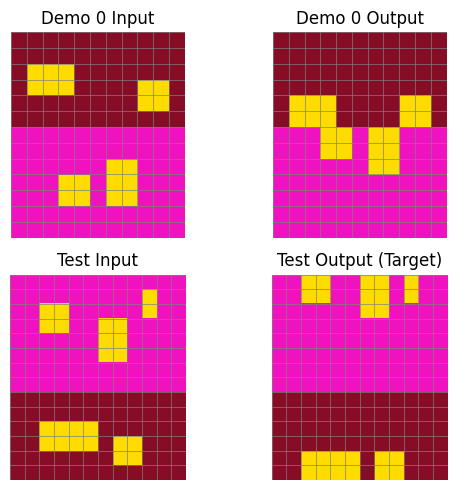

In [ ]:
# Get one batch and visualize
for split, batch, global_bs in dataset:
    print(f'Batch shapes:')
    for k, v in batch.items():
        print(f'  {k}: {v.shape}')
    break

# Visualize first episode in batch
demo_inputs = batch['demo_inputs'][0]  # (K, 900)
demo_labels = batch['demo_labels'][0]  # (K, 900)
demo_mask = batch['demo_mask'][0]      # (K,)
test_input = batch['inputs'][0]        # (900,)
test_label = batch['labels'][0]        # (900,)

num_demos = demo_mask.sum().item()
print(f'\nEpisode has {num_demos} demos')

fig, axes = plt.subplots(num_demos + 1, 2, figsize=(6, 2.5 * (num_demos + 1)))

for i in range(num_demos):
    plot_grid(demo_inputs[i].numpy(), axes[i, 0], f'Demo {i} Input')
    plot_grid(demo_labels[i].numpy(), axes[i, 1], f'Demo {i} Output')

plot_grid(test_input.numpy(), axes[num_demos, 0], 'Test Input')
plot_grid(test_label.numpy(), axes[num_demos, 1], 'Test Output (Target)')

plt.tight_layout()
plt.show()

## 6. Evaluation Dataset

Number of eval puzzles: 400

Puzzle: 50a16a69
Demos: 3, Tests: 1


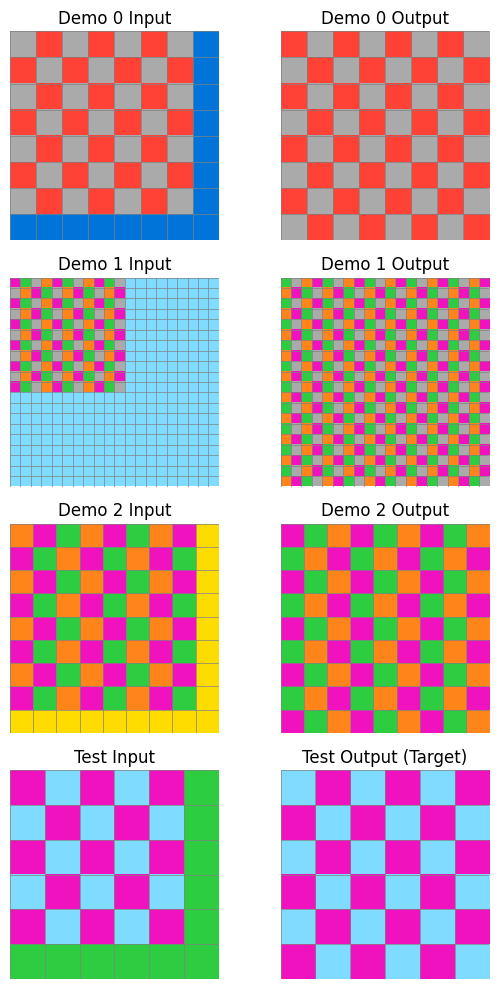

In [ ]:
# Load evaluation dataset
eval_dataset = FewShotEvalDataset('../data/arc1concept-aug-1000', max_demos=5)
print(f'Number of eval puzzles: {len(eval_dataset)}')

# Visualize one eval episode
episode = eval_dataset[0]
print(f"\nPuzzle: {episode['puzzle_id']}")
print(f"Demos: {episode['num_demos']}, Tests: {episode['num_tests']}")

num_demos = episode['num_demos']
fig, axes = plt.subplots(num_demos + 1, 2, figsize=(6, 2.5 * (num_demos + 1)))

for i in range(num_demos):
    plot_grid(episode['demo_inputs'][i].numpy(), axes[i, 0], f'Demo {i} Input')
    plot_grid(episode['demo_labels'][i].numpy(), axes[i, 1], f'Demo {i} Output')

plot_grid(episode['test_inputs'][0].numpy(), axes[num_demos, 0], 'Test Input')
plot_grid(episode['test_labels'][0].numpy(), axes[num_demos, 1], 'Test Output (Target)')

plt.tight_layout()
plt.show()